In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymc_marketing import clv
import arviz as az
import pymc as pm
from scipy.stats import beta

In [96]:
orders = pd.read_csv('data/olist/olist_orders_dataset.csv')
payments = pd.read_csv('data/olist/olist_order_payments_dataset.csv')
order_items = pd.read_csv('data/olist/olist_order_items_dataset.csv')
sellers = pd.read_csv('data/olist/olist_sellers_dataset.csv')

In [97]:
order_items_agg = order_items.groupby('order_id').agg(
    seller_id=('seller_id', 'first')
).reset_index()

In [98]:
orders = orders.loc[orders['order_status'] == 'delivered']
orders = orders[["order_id", "order_purchase_timestamp"]]

payments = payments[["order_id", "payment_value"]]
payments = payments.groupby("order_id").sum().reset_index()

In [99]:
merged = pd.merge(orders, payments, on='order_id', how='inner')
merged.order_purchase_timestamp = pd.to_datetime(merged.order_purchase_timestamp)
merged = pd.merge(merged, order_items_agg, on='order_id', how='left')

In [100]:
data = merged.groupby('seller_id').agg(
    monetary_value=('payment_value', 'mean'),
    frequency=('order_id', lambda x: len(x)-1),
    recency = ("order_purchase_timestamp", lambda x: (merged['order_purchase_timestamp'].max() - x.max()).days),
    T = ("order_purchase_timestamp", lambda x: (merged['order_purchase_timestamp'].max() - x.min()).days)
)

data = data.loc[data.frequency!=0]

# data.to_csv("data/olist/analysis_data.csv")

In [ ]:
data.hist()

In [32]:
data["log_freq"] = np.log(data["frequency"])
data["log_monetary"] = np.log(data["monetary_value"])

In [ ]:
data[["log_freq", "log_monetary"]].hist()

In [11]:
beta_geo_model = clv.BetaGeoModel(
    customer_id=data.index,
    frequency=np.log(data["freq"]),
    recency=data["recency"],
    T=data["T"],
    a_prior=pm.HalfNormal.dist(10),
    b_prior=pm.HalfNormal.dist(10),
    alpha_prior=pm.HalfNormal.dist(10),
    r_prior=pm.HalfNormal.dist(10),
)

In [ ]:
beta_geo_model.fit()

In [13]:
beta_geo_model.fit_summary()

/home/laurinbrechter/.local/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,22.408,2.499,17.531,26.888,0.086,0.061,825.0,898.0,1.01
b,46.915,5.221,37.845,57.238,0.183,0.130,806.0,1105.0,1.01
alpha,1.445,0.092,1.280,1.630,0.003,0.002,880.0,890.0,1.00
r,0.323,0.010,0.304,0.341,0.000,0.000,947.0,951.0,1.00


In [ ]:
a, b = 22.4, 47

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
fig, ax = plt.subplots(1,1)
ax.plot(x, beta.pdf(x, a, b), alpha=0.6)
ax.set_title('Beta Distribution for a=22.4, b=47')
ax.set_xlabel('p')
ax.set_ylabel('pdf')

Gamma-Gamma Model

In [101]:
from sklearn.preprocessing import LabelEncoder

In [102]:
data = pd.read_csv("data/olist/analysis_data.csv")
customer_id=LabelEncoder().fit_transform(merged.seller_id.values)
z_i = merged.payment_value.values

In [103]:
coords = {
    "seller_id": np.unique(customer_id),
    "transactions": range(len(customer_id))
    }

In [104]:
with pm.Model(coords=coords) as model:
    p = pm.HalfFlat("p")
    q = pm.HalfFlat("q")
    d = pm.HalfFlat("d")

    v = pm.Gamma("v", q, d, dims=("seller_id",))
    pm.Gamma("spend", p, v[customer_id], observed=z_i, dims=("transactions",))

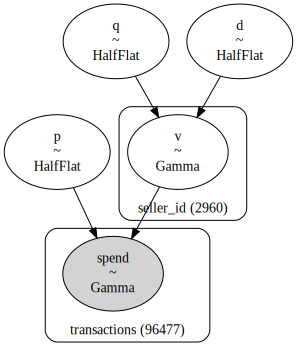

In [105]:
pm.model_to_graphviz(model)

In [62]:
model_ind = clv.GammaGammaModelIndividual(
    customer_id=LabelEncoder().fit_transform(merged.seller_id.values),
    individual_transaction_value=merged.payment_value.values
)

In [ ]:
model_ind.fit()

In [87]:
model = clv.GammaGammaModel(
    customer_id=data.index,
    frequency=data.frequency,
    mean_transaction_value=data.monetary_value,
)

In [88]:
trace = model.fit()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [89]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,7.452,2.510,3.986,11.382,0.170,0.129,382.0,264.0,1.01
q,2.222,0.071,2.100,2.363,0.003,0.002,690.0,787.0,1.00
v,37.526,10.661,15.487,55.943,0.538,0.381,371.0,283.0,1.01


In [91]:
expected_spend = model.expected_customer_spend(
    customer_id=data.index,
    frequency=data.frequency,
    mean_transaction_value=data.monetary_value
)

In [93]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[0],858.342,15.555,831.832,890.903
x[1],169.977,0.010,169.955,169.995
x[2],43.342,0.175,42.973,43.643
x[3],148.143,0.020,148.103,148.179
x[4],107.099,0.420,106.336,107.953
x[5],175.160,0.013,175.134,175.185
x[6],148.695,0.030,148.634,148.749
x[7],646.711,19.388,614.302,688.629
x[8],59.200,3.459,52.519,65.922
x[9],92.101,0.265,91.604,92.626


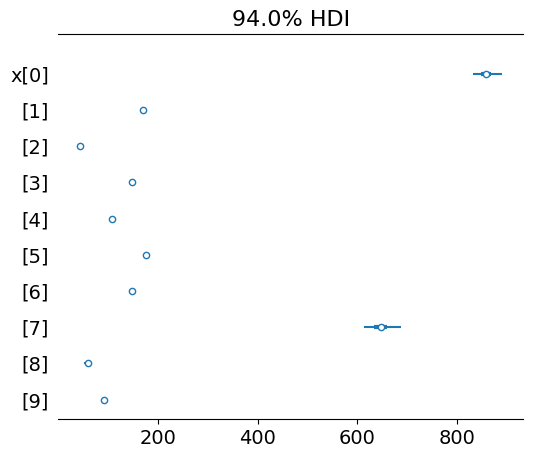

In [94]:
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True)